# RELAX: Representation Learning Explainability

This notebook illustrates the usage of RELAX, a framework for explainability in representation learning. RELAX is based on measuring similarities in the representation space between an input and occluded versions of itself. Our analysis of RELAX shows that the proposed method can be considered a linear scoring function in a reproducing kernel Hilbert space in the form of an inner produced product between unmasked input and the mean of the masked representations. For more information see the [International Journal of Computer Vision paper](https://link.springer.com/article/10.1007/s11263-023-01773-2#citeas) or the [ArXiv paper](https://arxiv.org/pdf/2112.10161.pdf).







In [1]:
#@title Download examples
#@markdown We download a selection of images from
#@markdown https://commons.wikimedia.org to illustrate the usage of RELAX.

!wget 'https://upload.wikimedia.org/wikipedia/commons/e/ee/Cat_in_Cat_Caf%C3%A9_Nekokaigi%2C_Tokyo%2C_February_2013.jpg'
!wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Tringa_totanus-pjt.jpg/640px-Tringa_totanus-pjt.jpg'
!wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Two_Cats_in_a_Corner.jpg/640px-Two_Cats_in_a_Corner.jpg'


--2023-11-20 13:13:24--  https://upload.wikimedia.org/wikipedia/commons/e/ee/Cat_in_Cat_Caf%C3%A9_Nekokaigi%2C_Tokyo%2C_February_2013.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 201984 (197K) [image/jpeg]
Saving to: ‘Cat_in_Cat_Café_Nekokaigi,_Tokyo,_February_2013.jpg.1’

Cat_in_Cat_Café_Nek 100%[===================>] 197.25K  --.-KB/s    in 0.06s   

2023-11-20 13:13:24 (3.48 MB/s) - ‘Cat_in_Cat_Café_Nekokaigi,_Tokyo,_February_2013.jpg.1’ saved [201984/201984]

--2023-11-20 13:13:24--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Tringa_totanus-pjt.jpg/640px-Tringa_totanus-pjt.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP requ

In [2]:
#@title Load packages


import torch
import torchvision
import torch.nn as nn
import tqdm.notebook as tqdm
import torch.nn.functional as F
import matplotlib.gridspec as gridspec

from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms import ToTensor, Normalize, Resize


/home/eperst/miniconda3/envs/relax/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
#@title Function for rescaling and displaying images.
#@markdown This function is taken from the TorchRay library (https://github.com/facebookresearch/TorchRay).

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

In [10]:
#@title Function for loading data
#@markdown This function loads the example images downloaded in one of the previous cells.

def load_img(img, shape=224):
    if img == 'Ex1':
        img = Image.open(
            './relax_pics/Cat_in_Cat_Café_Nekokaigi,_Tokyo,_February_2013.jpg'
            )
    elif img == 'Ex2':
        img = Image.open(
            './relax_pics/640px-Tringa_totanus-pjt.jpg'
            )
    elif img == 'Ex3':
        img = Image.open(
            './relax_pics/640px-Two_Cats_in_a_Corner.jpg'
            )
    else:
        print('Incorrect keyword')
        raise

    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((shape, shape)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
    ])

    x = transform(img).unsqueeze(0)

    return x

In [11]:
#@title Load feature extractors
#@markdown This cell created functions for loading the feature extractors considered
#@markdown in this notebook. An image is represented by the output of the
#@markdown adaptive pooling layer towards the end of the ResNet50 or Alexnet architecture.

def load_resnet50():
  resnet50 = torchvision.models.resnet50(weights="DEFAULT")
  modules = list(resnet50.children())[:-1]
  encoder = nn.Sequential(*modules, nn.Flatten())
  encoder.eval()
  return encoder

def load_alexnet():
  alexnet = torchvision.models.alexnet(weights="DEFAULT")
  encoder = nn.Sequential(alexnet.features,
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)),
                          nn.Flatten())
  encoder.eval()
  return encoder




In [12]:
#@title Create mask generator
#@markdown This function implements the generator for creating masks in our framework.
#@markdown The implementation is based on the TorchRay implementation and the
#@markdown RISE implementation at: https://github.com/eclique/RISE.

def MaskGenerator(iterations, inp_shape, num_cells=7, mask_bs=2, p=0.5, nsd=2, dev='cpu'):
    for iteration in range(iterations):

        pad_size = (num_cells // 2, num_cells // 2, num_cells // 2, num_cells // 2)
        grid = (torch.rand(mask_bs, 1, *((num_cells,) * nsd), device=dev) < p).float()

        grid_up = F.interpolate(grid, size=(inp_shape), mode='bilinear', align_corners=False)
        grid_up = F.pad(grid_up, pad_size, mode='reflect')

        shift_x = torch.randint(0, num_cells, (mask_bs,), device='cpu')
        shift_y = torch.randint(0, num_cells, (mask_bs,), device='cpu')

        masks = torch.empty((mask_bs, 1, inp_shape, inp_shape), device=dev)

        for i in range(mask_bs):
            masks[i] = grid_up[i, :,
                               shift_x[i]:shift_x[i] + inp_shape,
                               shift_y[i]:shift_y[i] + inp_shape]

        yield masks



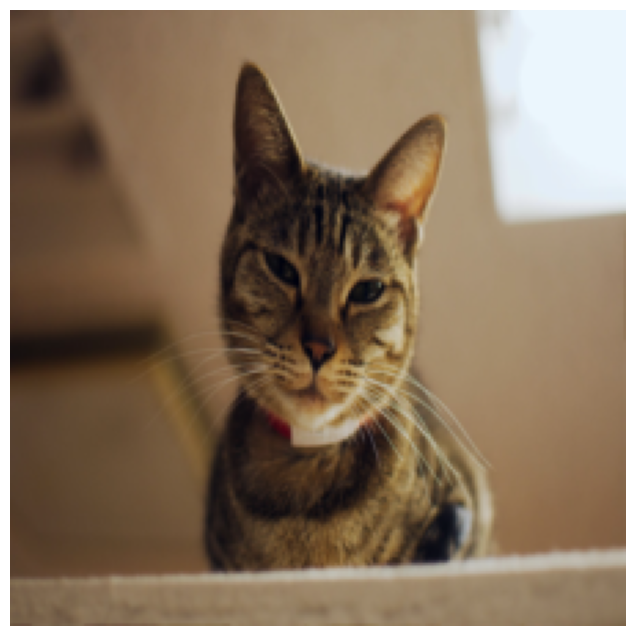

In [14]:
#@title Load first example

x = load_img('Ex1')

plt.figure(1, figsize=(8, 8))
plt.imshow(imsc(x[0]))
plt.axis('off')
plt.show()

In [25]:
#@title Run RELAX on example 1
#@markdown This cell runs RELAX on example image 1. For all details on RELAX, please
#@markdown see our full paper. This cell will run through all feature extractors for
#@markdown the given image.

torch.manual_seed(100)

pdist = nn.CosineSimilarity(dim=1)

model_name_list = ['resnet50', 'alexnet']
model_list = [load_resnet50, load_alexnet]

mask_bs, inp_shape, num_batches = 100, 224, 80

with torch.no_grad():
  for model_loader, model_name in zip(model_list, model_name_list):

      model = model_loader()
      h_star = model(x)
      h_star = h_star.expand(mask_bs, -1)

      saliency = torch.zeros((inp_shape, inp_shape), device='cpu')
      saliency_var = torch.zeros((inp_shape, inp_shape), device='cpu')

      for mask_idx, mask in enumerate(MaskGenerator(
                                                num_batches, (inp_shape), mask_bs=mask_bs)):
          x_mask = x * mask
          out = model(x_mask)
          out = pdist(h_star, out)[:, None, None, None]
          saliency += torch.mean(out * mask, dim=(0, 1))

      saliency /= (num_batches*0.5)

      for mask_idx, mask in enumerate(MaskGenerator(num_batches, (inp_shape), mask_bs=mask_bs)):
          x_mask = x * mask
          out = model(x_mask)

          out = pdist(h_star, out)[:, None, None, None]
          var = (out-saliency[None, None])**2
          var = torch.mean(var * mask, dim=(0, 1))

          saliency_var += var

      saliency_var /= ((num_batches-1)*0.5)

      if model_name == 'resnet50':
          saliency_resnet50 = saliency
          saliency_var_resnet50 = saliency_var
      elif model_name == 'alexnet':
          saliency_alexnet = saliency
          saliency_var_alexnet = saliency_var



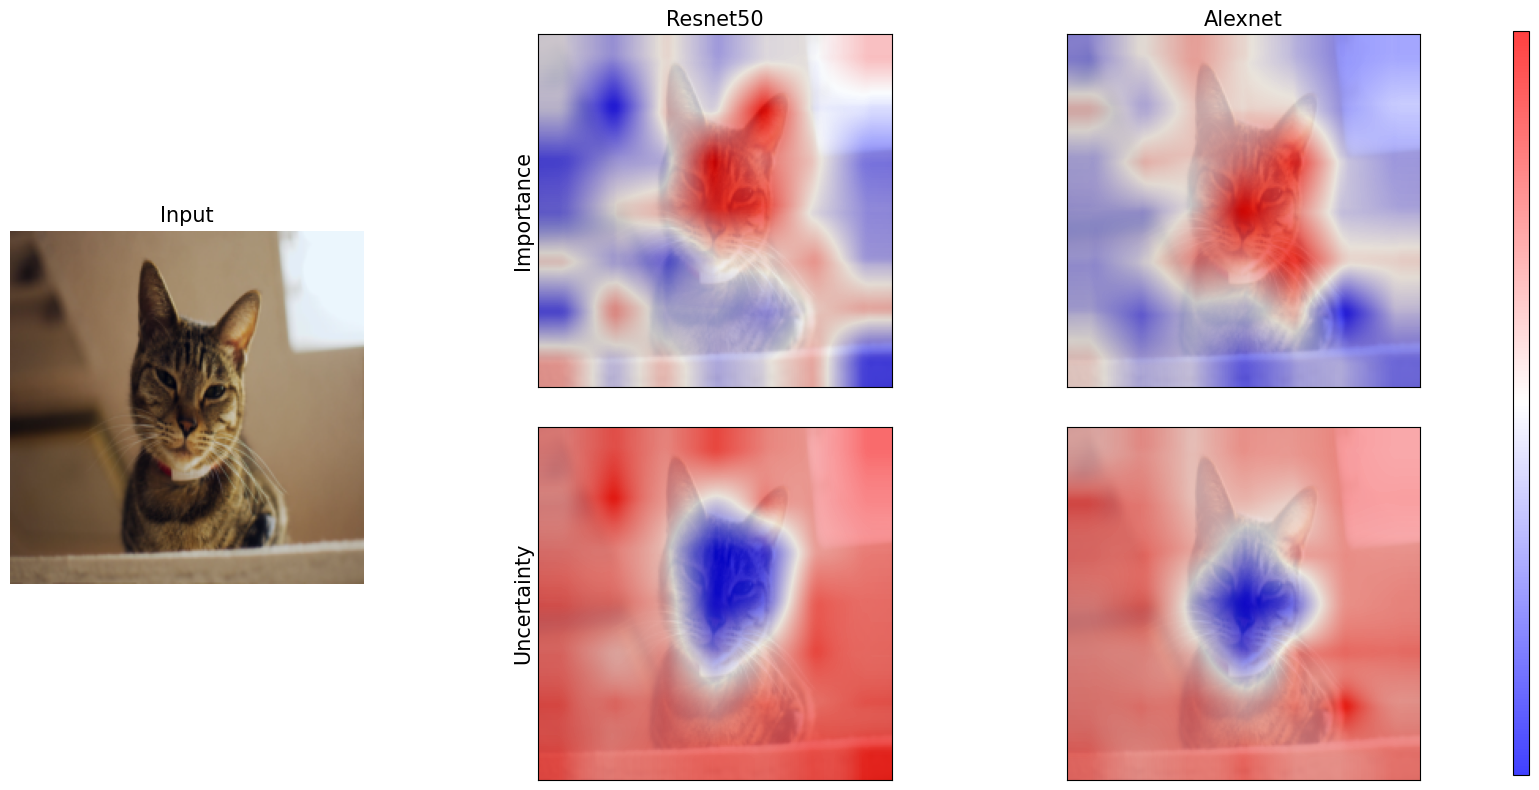

In [23]:
#@title Display results for example 1.

fig = plt.figure(1, figsize=(16, 8))
gs = gridspec.GridSpec(4, 6)
ax1a = plt.subplot(gs[1:3, 0:2])
ax1a.imshow(imsc(x[0]))
ax1a.axis('off')
ax1a.set_title('Input', fontsize=15)
ax2a = plt.subplot(gs[0:2, 2:4])
ax2a.imshow(imsc(x[0]))
im = ax2a.imshow(saliency_resnet50.cpu(), alpha=0.75, cmap='bwr')
ax2a.set_xticks([])
ax2a.set_yticks([])
ax2a.set_ylabel('Importance', fontsize=15)
ax2a.set_title('Resnet50', fontsize=15)
ax3a = plt.subplot(gs[2:4, 2:4])
ax3a.imshow(imsc(x[0]))
ax3a.imshow(saliency_var_resnet50.cpu(), alpha=0.75, cmap='bwr')
ax3a.set_xticks([])
ax3a.set_yticks([])
ax3a.set_ylabel('Uncertainty', fontsize=15)
ax4a = plt.subplot(gs[0:2, 4:6])
ax4a.imshow(imsc(x[0]))
ax4a.set_xticks([])
ax4a.set_yticks([])
ax4a.set_title('Alexnet', fontsize=15)
ax4a.imshow(saliency_alexnet.cpu(), alpha=0.75, cmap='bwr')
ax5a = plt.subplot(gs[2:4, 4:6])
ax5a.imshow(imsc(x[0]))
ax5a.imshow(saliency_var_alexnet.cpu(), alpha=0.75, cmap='bwr')
ax5a.set_xticks([])
ax5a.set_yticks([])

plt.tight_layout()

cbar_ax = fig.add_axes([0.999, 0.025, 0.01, 0.93])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([])

plt.show()

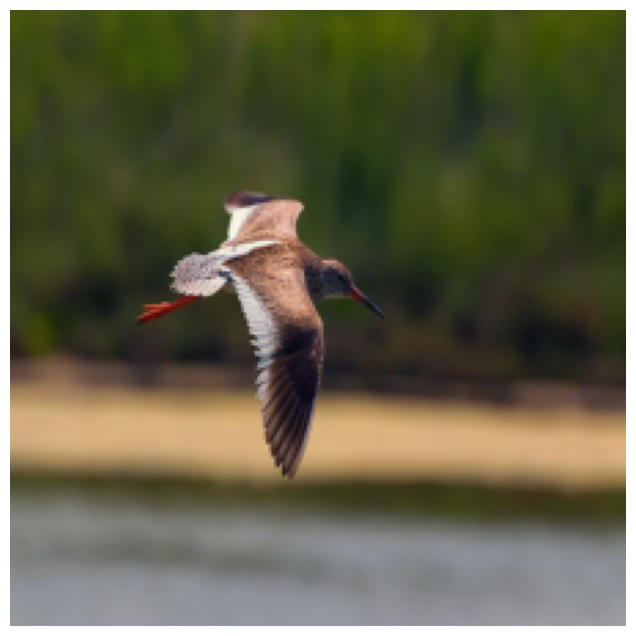

In [24]:
#@title Load second example

x = load_img('Ex2')

plt.figure(1, figsize=(8, 8))
plt.imshow(imsc(x[0]))
plt.axis('off')
plt.show()

In [26]:
#@title Run RELAX on example 1
#@markdown This cell runs RELAX on example image 1. For all details on RELAX, please
#@markdown see our full paper. This cell will run through all feature extractors for
#@markdown the given image.

torch.manual_seed(100)

pdist = nn.CosineSimilarity(dim=1)

model_name_list = ['resnet50', 'alexnet']
model_list = [load_resnet50, load_alexnet]

mask_bs, inp_shape, num_batches = 100, 224, 80

with torch.no_grad():
  for model_loader, model_name in zip(model_list, model_name_list):

      model = model_loader()
      h_star = model(x)
      h_star = h_star.expand(mask_bs, -1)

      saliency = torch.zeros((inp_shape, inp_shape), device='cpu')
      saliency_var = torch.zeros((inp_shape, inp_shape), device='cpu')

      for mask_idx, mask in enumerate(tqdm.tqdm(MaskGenerator(
                                                num_batches, (inp_shape), mask_bs=mask_bs),
                                                total=num_batches,
                                                desc=f"Compute {model_name} importance")):

          x_mask = x * mask
          out = model(x_mask)

          out = pdist(h_star, out)[:, None, None, None]

          saliency += torch.mean(out * mask, dim=(0, 1))

      saliency /= (num_batches*0.5)

      for mask_idx, mask in enumerate(tqdm.tqdm(MaskGenerator(num_batches, (inp_shape), mask_bs=mask_bs),
                            total=num_batches, desc=f"Compute {model_name} uncertainty")):

          x_mask = x * mask
          out = model(x_mask)

          out = pdist(h_star, out)[:, None, None, None]

          var = (out-saliency[None, None])**2
          var = torch.mean(var * mask, dim=(0, 1))

          saliency_var += var

      saliency_var /= ((num_batches-1)*0.5)

      if model_name == 'resnet50':
          saliency_resnet50 = saliency
          saliency_var_resnet50 = saliency_var
      elif model_name == 'alexnet':
          saliency_alexnet = saliency
          saliency_var_alexnet = saliency_var



Compute resnet50 importance:   0%|          | 0/80 [00:00<?, ?it/s]

Compute resnet50 uncertainty:   0%|          | 0/80 [00:00<?, ?it/s]

Compute alexnet importance:   0%|          | 0/80 [00:00<?, ?it/s]

Compute alexnet uncertainty:   0%|          | 0/80 [00:00<?, ?it/s]

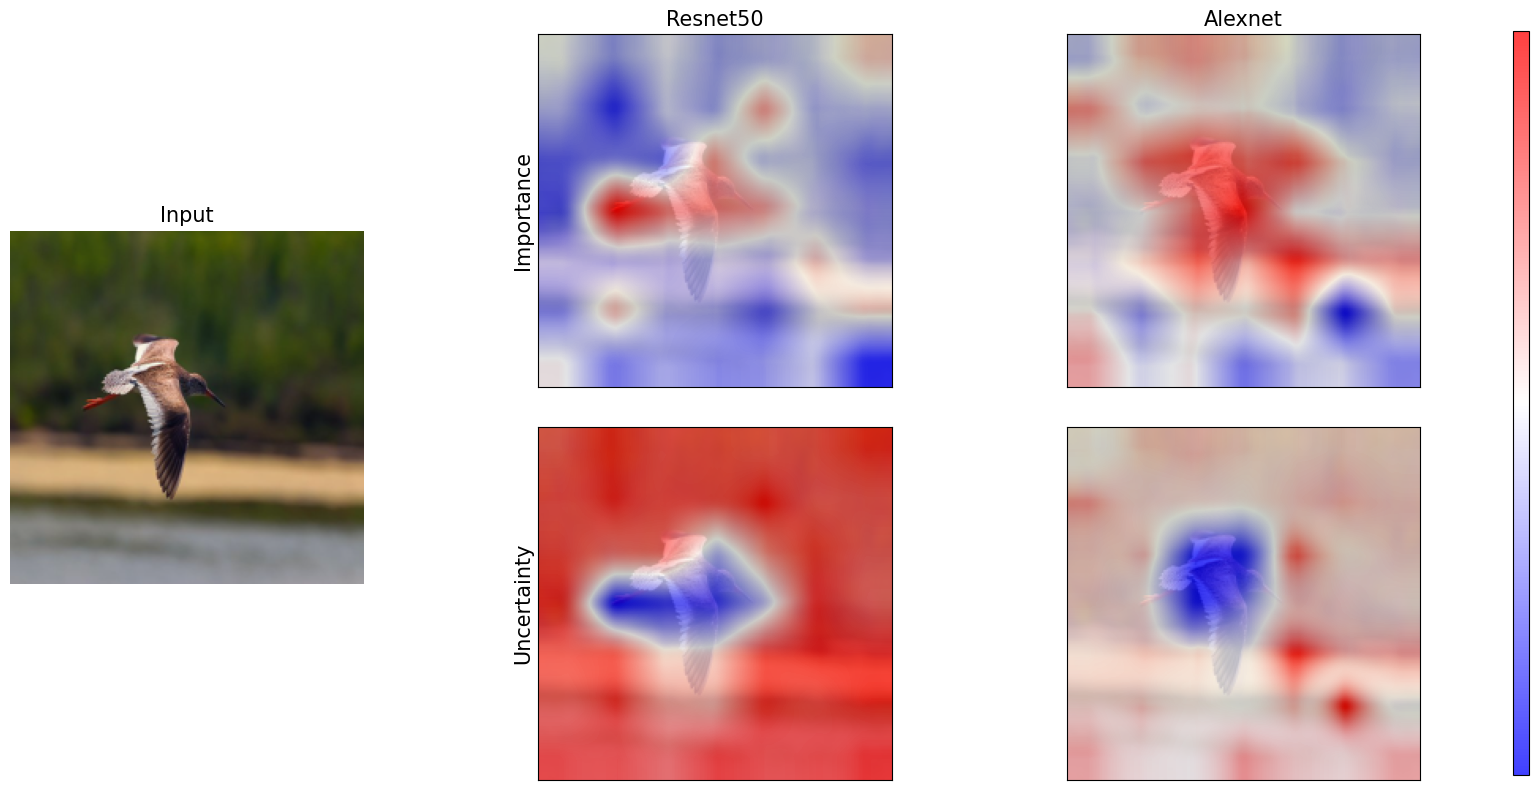

In [27]:
#@title Display results for example 2.

fig = plt.figure(1, figsize=(16, 8))
gs = gridspec.GridSpec(4, 6)
ax1a = plt.subplot(gs[1:3, 0:2])
ax1a.imshow(imsc(x[0]))
ax1a.axis('off')
ax1a.set_title('Input', fontsize=15)
ax2a = plt.subplot(gs[0:2, 2:4])
ax2a.imshow(imsc(x[0]))
im = ax2a.imshow(saliency_resnet50.cpu(), alpha=0.75, cmap='bwr')
ax2a.set_xticks([])
ax2a.set_yticks([])
ax2a.set_ylabel('Importance', fontsize=15)
ax2a.set_title('Resnet50', fontsize=15)
ax3a = plt.subplot(gs[2:4, 2:4])
ax3a.imshow(imsc(x[0]))
ax3a.imshow(saliency_var_resnet50.cpu(), alpha=0.75, cmap='bwr')
ax3a.set_xticks([])
ax3a.set_yticks([])
ax3a.set_ylabel('Uncertainty', fontsize=15)
ax4a = plt.subplot(gs[0:2, 4:6])
ax4a.imshow(imsc(x[0]))
ax4a.set_xticks([])
ax4a.set_yticks([])
ax4a.set_title('Alexnet', fontsize=15)
ax4a.imshow(saliency_alexnet.cpu(), alpha=0.75, cmap='bwr')
ax5a = plt.subplot(gs[2:4, 4:6])
ax5a.imshow(imsc(x[0]))
ax5a.imshow(saliency_var_alexnet.cpu(), alpha=0.75, cmap='bwr')
ax5a.set_xticks([])
ax5a.set_yticks([])

plt.tight_layout()

cbar_ax = fig.add_axes([0.999, 0.025, 0.01, 0.93])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([])

plt.show()

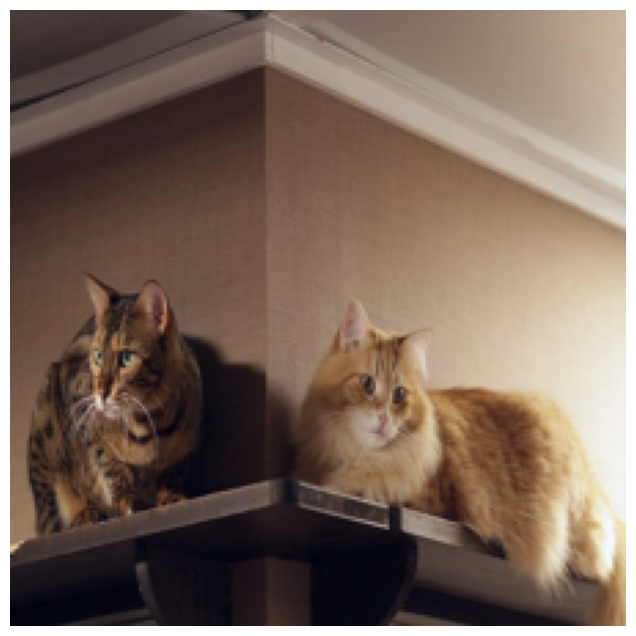

In [19]:
#@title Load third example

x = load_img('Ex3')

plt.figure(1, figsize=(8, 8))
plt.imshow(imsc(x[0]))
plt.axis('off')
plt.show()

In [20]:
#@title Run RELAX on example e
#@markdown This cell runs RELAX on example image 1. For all details on RELAX, please
#@markdown see our full paper. This cell will run through all feature extractors for
#@markdown the given image.

torch.manual_seed(100)

pdist = nn.CosineSimilarity(dim=1)

model_name_list = ['resnet50', 'alexnet']
model_list = [load_resnet50, load_alexnet]

mask_bs, inp_shape, num_batches = 100, 224, 80

with torch.no_grad():
  for model_loader, model_name in zip(model_list, model_name_list):

      model = model_loader()
      h_star = model(x)
      h_star = h_star.expand(mask_bs, -1)

      saliency = torch.zeros((inp_shape, inp_shape), device='cpu')
      saliency_var = torch.zeros((inp_shape, inp_shape), device='cpu')

      for mask_idx, mask in enumerate(tqdm.tqdm(MaskGenerator(
                                                num_batches, (inp_shape), mask_bs=mask_bs),
                                                total=num_batches,
                                                desc=f"Compute {model_name} importance")):

          x_mask = x * mask
          out = model(x_mask)

          out = pdist(h_star, out)[:, None, None, None]

          saliency += torch.mean(out * mask, dim=(0, 1))

      saliency /= (num_batches*0.5)

      for mask_idx, mask in enumerate(tqdm.tqdm(MaskGenerator(num_batches, (inp_shape), mask_bs=mask_bs),
                            total=num_batches, desc=f"Compute {model_name} uncertainty")):

          x_mask = x * mask
          out = model(x_mask)

          out = pdist(h_star, out)[:, None, None, None]

          var = (out-saliency[None, None])**2
          var = torch.mean(var * mask, dim=(0, 1))

          saliency_var += var

      saliency_var /= ((num_batches-1)*0.5)

      if model_name == 'resnet50':
          saliency_resnet50 = saliency
          saliency_var_resnet50 = saliency_var
      elif model_name == 'alexnet':
          saliency_alexnet = saliency
          saliency_var_alexnet = saliency_var



Compute resnet50 importance:   0%|          | 0/80 [00:00<?, ?it/s]

Compute resnet50 uncertainty:   0%|          | 0/80 [00:00<?, ?it/s]

Compute alexnet importance:   0%|          | 0/80 [00:00<?, ?it/s]

Compute alexnet uncertainty:   0%|          | 0/80 [00:00<?, ?it/s]

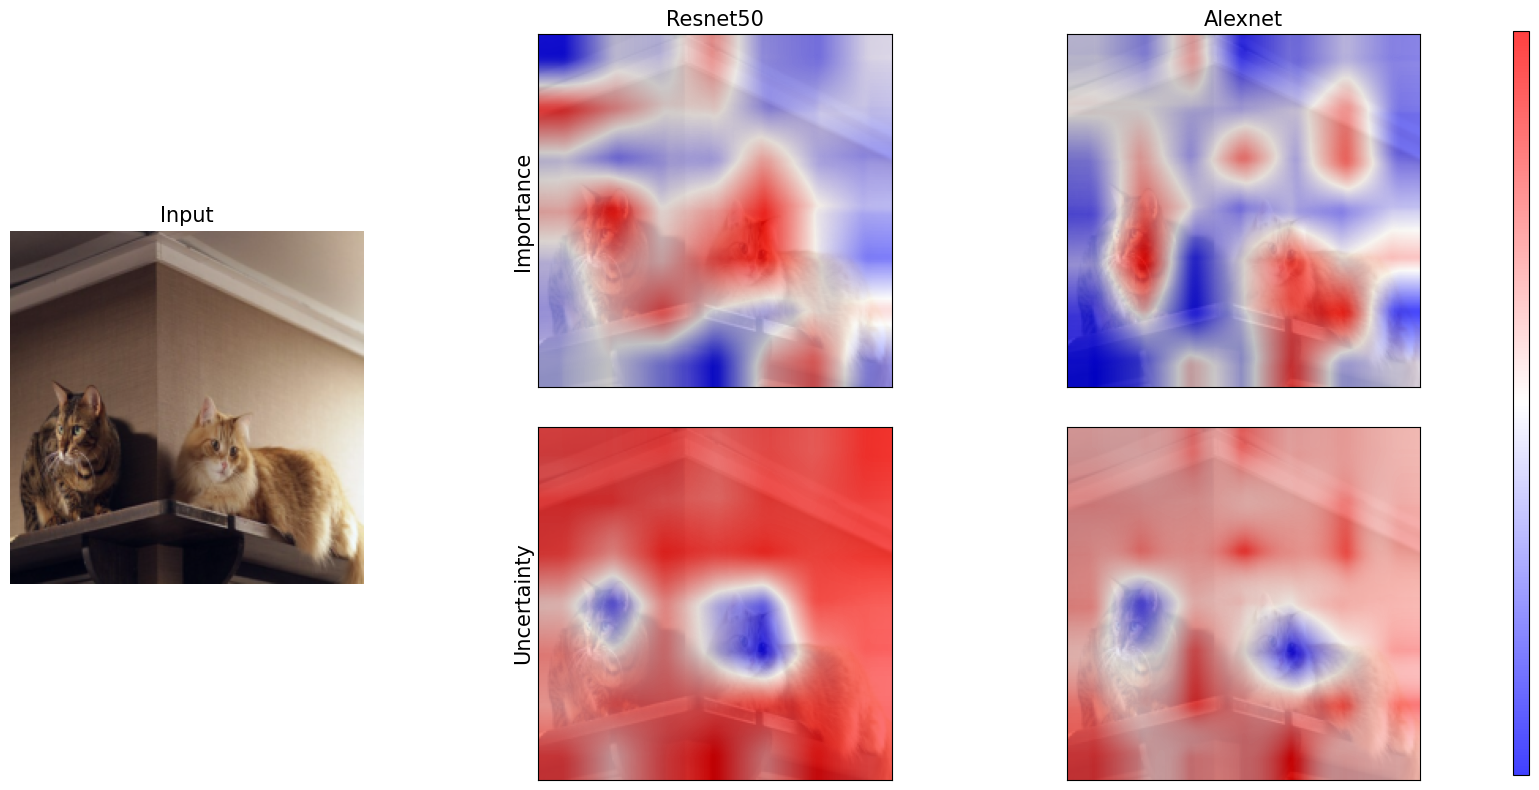

In [21]:
#@title Display results for example 3.

fig = plt.figure(1, figsize=(16, 8))
gs = gridspec.GridSpec(4, 6)
ax1a = plt.subplot(gs[1:3, 0:2])
ax1a.imshow(imsc(x[0]))
ax1a.axis('off')
ax1a.set_title('Input', fontsize=15)
ax2a = plt.subplot(gs[0:2, 2:4])
ax2a.imshow(imsc(x[0]))
im = ax2a.imshow(saliency_resnet50.cpu(), alpha=0.75, cmap='bwr')
ax2a.set_xticks([])
ax2a.set_yticks([])
ax2a.set_ylabel('Importance', fontsize=15)
ax2a.set_title('Resnet50', fontsize=15)
ax3a = plt.subplot(gs[2:4, 2:4])
ax3a.imshow(imsc(x[0]))
ax3a.imshow(saliency_var_resnet50.cpu(), alpha=0.75, cmap='bwr')
ax3a.set_xticks([])
ax3a.set_yticks([])
ax3a.set_ylabel('Uncertainty', fontsize=15)
ax4a = plt.subplot(gs[0:2, 4:6])
ax4a.imshow(imsc(x[0]))
ax4a.set_xticks([])
ax4a.set_yticks([])
ax4a.set_title('Alexnet', fontsize=15)
ax4a.imshow(saliency_alexnet.cpu(), alpha=0.75, cmap='bwr')
ax5a = plt.subplot(gs[2:4, 4:6])
ax5a.imshow(imsc(x[0]))
ax5a.imshow(saliency_var_alexnet.cpu(), alpha=0.75, cmap='bwr')
ax5a.set_xticks([])
ax5a.set_yticks([])

plt.tight_layout()

cbar_ax = fig.add_axes([0.999, 0.025, 0.01, 0.93])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([])

plt.show()